# Part II - Ford GoBike
##by Tala Jebrini

## Investigation Overview

The goal of this presentation is to clearly communicate the most important insights uncovered from the Ford GoBike System Data for February 2019. These insights were derived through exploratory data analysis and are now refined into clean, focused visualizations for stakeholders and non-technical audiences.

The primary questions investigated include:
- How does trip duration vary by user type, time of day, and day of the week?
- What are the behavioral differences between Subscribers and Customers?
- How do gender and program participation (Bike Share for All) relate to these patterns?

---

## Executive Summary of Key Findings

1. **Subscribers vs. Customers**:
   - Subscribers take the majority of trips, mostly on weekdays, and their trips are short and routine.
   - Customers take fewer trips, but they are significantly longer, especially on weekends and mid-day hours.

2. **Time-Based Patterns**:
   - Peak Subscriber usage occurs during **commuting hours** (7–9 AM and 4–6 PM).
   - Customer usage is higher **midday and weekends**, suggesting recreational or casual behavior.

3. **Program Participation**:
   - Participation in the “Bike Share for All” program is most common among **male Subscribers**.
   - Customers and female riders show very low participation in the program.

These findings will be supported by 3–5 well-designed visualizations in the remainder of this notebook.

---

## Dataset Overview

The dataset used is the **Ford GoBike Trip Data** for **February 2019**, covering 183,412 individual bike trips in the San Francisco Bay Area. Each record includes trip duration, timestamps, station info, user type, and demographics such as birth year and gender. The dataset enables rich analysis of travel behavior by time, user group, and demographic segments.


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Dataset/201902-fordgobike-tripdata.csv'
bike = pd.read_csv(file_path)
bike.head()

Mounted at /content/drive


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


Cleaning from part 1

In [5]:
# Step 1: Convert time columns to datetime
bike['start_time'] = pd.to_datetime(bike['start_time'])
bike['end_time'] = pd.to_datetime(bike['end_time'])

# Step 2: Drop rows with missing demographic or station name data
bike_clean = bike.dropna(subset=['start_station_name', 'end_station_name', 'member_gender', 'member_birth_year'])

# Step 3: Filter out unrealistic trip durations (e.g., less than 1 minute or more than 2 hours)
bike_clean = bike_clean[(bike_clean['duration_sec'] >= 60) & (bike_clean['duration_sec'] <= 7200)]

# Step 4: Extract hour and day for later exploration
bike_clean['start_hour'] = bike_clean['start_time'].dt.hour
bike_clean['day_of_week'] = bike_clean['start_time'].dt.day_name()



## (Visualization 1)

 Average Trip Duration by Start Hour and User Type


In [3]:
def setup_plot(title='', xlabel='', ylabel='', figsize=(10, 6), log_x=False, rotation=0):
    """
    Set up a consistent plot layout for any seaborn/matplotlib chart.
    """
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_x:
        plt.xscale('log')
    plt.grid(True)
    plt.xticks(rotation=rotation)


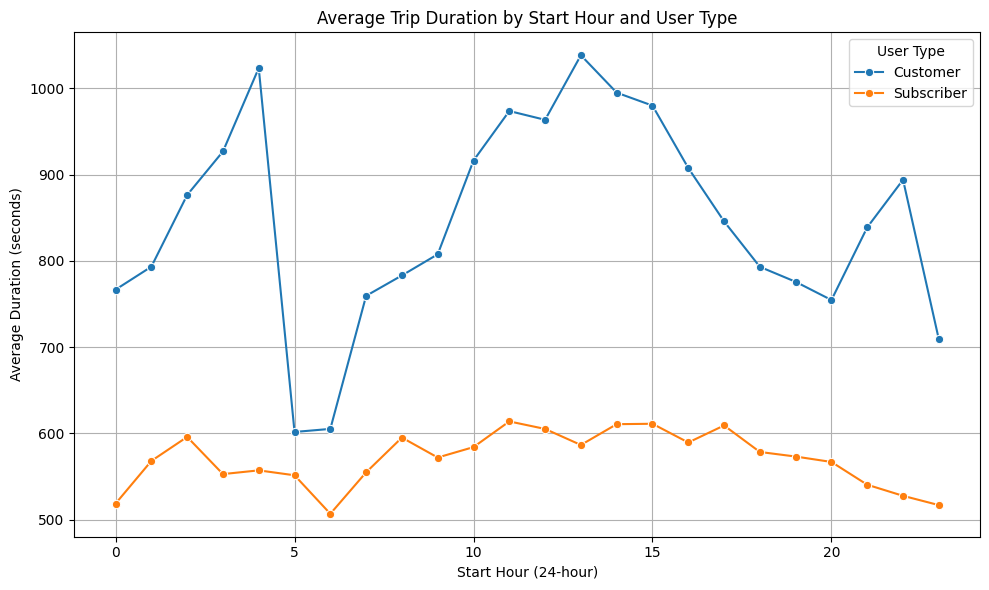

In [8]:
# Group and calculate average trip duration
avg_duration = bike_clean[bike_clean['duration_sec'] <= 3000].groupby(['start_hour', 'user_type'])['duration_sec'].mean().reset_index()

# Plot using your setup function
setup_plot(
    title='Average Trip Duration by Start Hour and User Type',
    xlabel='Start Hour (24-hour)',
    ylabel='Average Duration (seconds)'
)

sns.lineplot(data=avg_duration, x='start_hour', y='duration_sec', hue='user_type', marker='o')
plt.legend(title='User Type')
plt.tight_layout()


 Average Trip Duration by Start Hour and User Type

This line plot presents the average trip duration for both **Subscribers** and **Customers** across each hour of the day.

- **Customers** take significantly longer trips on average than Subscribers.
- Customer trip durations peak around **midday (12–15)** and again in the **evening**, which aligns with recreational or non-commute behavior.
- **Subscribers**, in contrast, maintain a relatively **flat average trip duration** with minor peaks during **commuting hours** (7–9 AM and 4–6 PM), confirming structured, work-related use.

This visualization makes the difference in trip behavior by user type very clear.


## (Visualization 2)

>Average Trip Duration by Hour and User Type (Faceted by Gender)

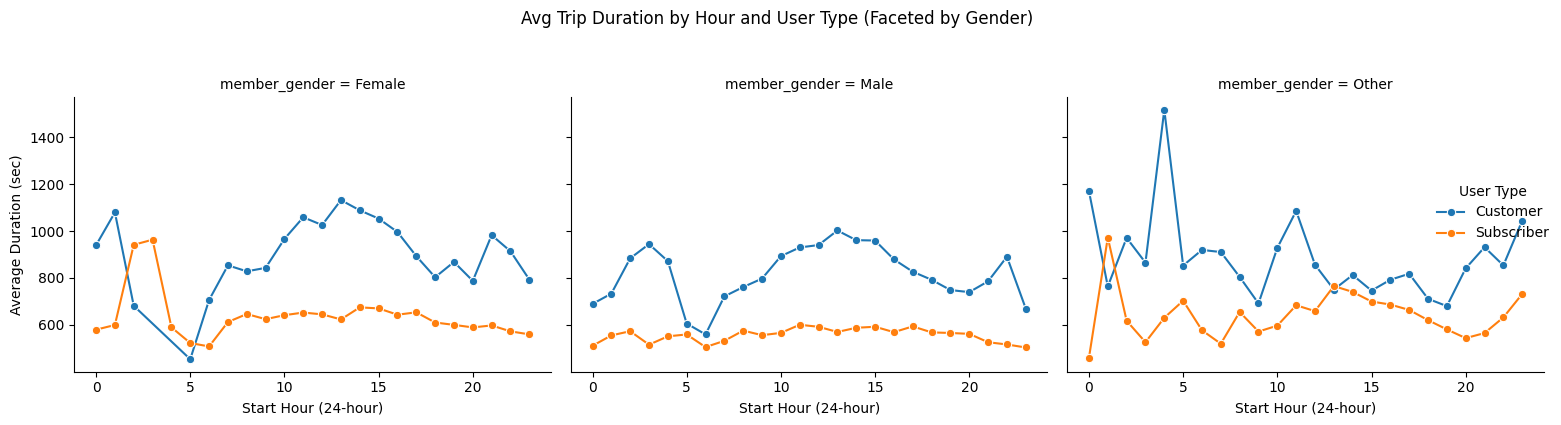

In [9]:
avg_gender = bike_clean[bike_clean['duration_sec'] <= 3000].groupby(['start_hour', 'user_type', 'member_gender'])['duration_sec'].mean().reset_index()

g = sns.FacetGrid(avg_gender, col='member_gender', height=4, aspect=1.2)
g.map_dataframe(sns.lineplot, x='start_hour', y='duration_sec', hue='user_type', marker='o')
g.add_legend(title='User Type')
g.set_axis_labels('Start Hour (24-hour)', 'Average Duration (sec)')
g.fig.suptitle('Avg Trip Duration by Hour and User Type (Faceted by Gender)', y=1.05)
plt.tight_layout()


Average Trip Duration by Hour and User Type (Faceted by Gender)

This faceted line plot breaks down the relationship shown in Visualization 1 by gender, offering a deeper look into how trip behavior differs across user demographics.

- **Male and female Customers** show similar patterns: longer trips during the day and early evening.
- **Subscribers** again show consistent behavior across all genders, with shorter trips centered around commuting hours.
- The **'Other' gender group**, though smaller, displays more variability, likely due to lower sample size.

This visualization confirms that **gender has minimal impact on trip patterns for Subscribers**, but **slightly more variation is visible for Customers**, especially in midday durations.


## (Visualization 3)

> Faceted count plot of program participation by user type and gender

Text(0.5, 0.98, "Participation in 'Bike Share for All' by Gender and User Type")

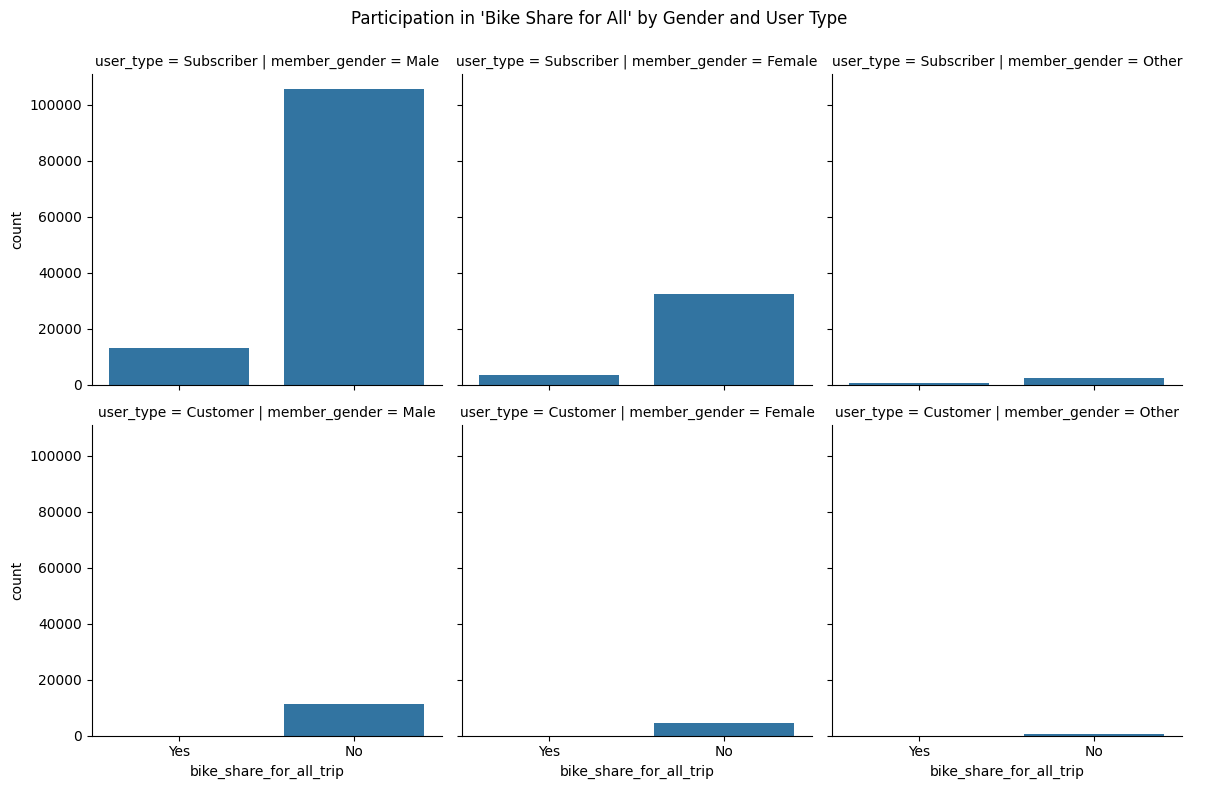

In [10]:

sns.catplot(
    data=bike_clean,
    kind="count",
    x="bike_share_for_all_trip",
    col="member_gender",
    row="user_type",
    height=4,
    aspect=1
)

plt.subplots_adjust(top=0.9)
plt.suptitle("Participation in 'Bike Share for All' by Gender and User Type")


 Participation in "Bike Share for All" by Gender and User Type


This faceted count plot illustrates how participation in the **"Bike Share for All"** program varies across user types and gender categories:

- **Subscribers** account for nearly all of the participation in the program.
- Among Subscribers, **male users** make up the largest share of participants, while **female** and **other** gender groups show lower participation.
- **Customers**, regardless of gender, rarely use the program — suggesting that it’s either not targeted toward or not effectively reaching casual riders.

This visualization highlights **program reach disparities**, and raises important questions about accessibility and equity in public transportation initiatives.


## Final Summary and Key Takeaways

This presentation highlighted the most important insights uncovered during the exploratory analysis of the Ford GoBike trip data for February 2019. The goal was to communicate usage patterns and behavioral trends through clean, informative, and focused visualizations.

### 🔑 Key Takeaways:

1. **Trip Duration Patterns**:
   - **Customers** consistently take longer trips than **Subscribers**, especially during midday and non-commuting hours.
   - **Subscribers** show a strong commuting pattern, with shorter, more uniform trips during peak hours.

2. **Gender Differences**:
   - Overall patterns of trip duration by hour are similar across gender groups.
   - Minor variations exist, with female Customers tending to have slightly higher midday durations.

3. **Bike Share for All Participation**:
   - The program is used primarily by **Subscribers**, with **male riders** representing the majority of participants.
   - **Customer participation is low** across all genders, indicating a potential need for better outreach or support for casual users.

These findings provide insights that can inform operational decisions, marketing strategies, and policy improvements — especially in the areas of **equity**, **accessibility**, and **user engagement**.

---

Thank you for reviewing this project!
